In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression

In [2]:
# Define the file path
drillholes_file_path = r'C:\Users\Ton\OneDrive\Desktop\Data_Institute\_prj_capstone\assays_mod.csv'

# Load the CSV file into a DataFrame
drillholes_df = pd.read_csv(drillholes_file_path)

# Columns to exclude
exclude_columns = ['X', 'Y', 'Z']

# Fill NaN values with 0 in all columns except the excluded ones
for column in drillholes_df.columns:
    if column not in exclude_columns:
        drillholes_df[column].fillna(0, inplace=True)

# Display the first few rows of the DataFrame to verify the changes
print(drillholes_df.head())
print(drillholes_df.info())

# Print basic statistics of the DataFrame
print(drillholes_df.describe())

           X           Y       Z  Au ppm  DomCode  Oxidation
0  636807.86  6850615.21  301.23    0.05        0          1
1  636807.57  6850615.63  300.37    0.00        0          1
2  636807.28  6850616.05  299.51    0.01        0          1
3  636806.99  6850616.47  298.65    0.00        0          1
4  636806.71  6850616.90  297.79    0.01        0          1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8109 entries, 0 to 8108
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   X          8109 non-null   float64
 1   Y          8109 non-null   float64
 2   Z          8109 non-null   float64
 3   Au ppm     8109 non-null   float64
 4   DomCode    8109 non-null   int64  
 5   Oxidation  8109 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 380.2 KB
None
                   X             Y            Z       Au ppm      DomCode  \
count    8109.000000  8.109000e+03  8109.000000  8109.000000  8109.000000 

### Data processing

In [3]:
# Define the preprocessing steps for numerical and categorical data
numeric_features = ['X', 'Y', 'Z']
categorical_features = ['DomCode', 'Oxidation']

# Preprocessing for numerical data: scaling
numeric_transformer = StandardScaler()

# Preprocessing for categorical data: one-hot encoding
categorical_transformer = OneHotEncoder()

In [4]:
# Select the features and target variable
X = drillholes_df[['X', 'Y', 'Z','DomCode','Oxidation']]
y = drillholes_df['Au ppm']

### Split the data (training/test)

In [5]:
# Stratify the data split
y_strat = pd.qcut(y, q=10, labels=False, duplicates='drop')

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_strat)

# Calculate the mean of the target variable from the training data
baseline_mean = y_train.mean()

# Predict the mean for all test data points
y_pred_baseline = np.full_like(y_test, baseline_mean)

# Calculate the Mean Squared Error (MSE) and R² score for the baseline model
baseline_mse = mean_squared_error(y_test, y_pred_baseline)
baseline_r2 = r2_score(y_test, y_pred_baseline)

print(f'Baseline Mean Squared Error: {baseline_mse:.2f}')
print(f'Baseline R² Score: {baseline_r2:.2f}')

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Apply the preprocessing steps to the training and test sets
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

Baseline Mean Squared Error: 0.85
Baseline R² Score: -0.00


### Create the stacking model

In [6]:
# Define the base models and their hyperparameters
base_models = [
    ('lr', LinearRegression()),
    ('knn', GridSearchCV(KNeighborsRegressor(), param_grid={'n_neighbors': [20, 40, 60]}, cv=3)),
    ('svc', GridSearchCV(SVR(), param_grid={'C': [5, 8, 10], 'kernel': ['linear', 'rbf']}, cv=3)),
    ('rf', GridSearchCV(RandomForestRegressor(), param_grid={'n_estimators': [5, 10, 15], 'max_depth': [None, 20, 30, 40]}, cv=3)),
    ('dt', GridSearchCV(DecisionTreeRegressor(), param_grid={'max_depth': [None, 1, 2, 3], 'min_samples_split': [5, 10, 15]}, cv=3)),
    ('gbm', GridSearchCV(GradientBoostingRegressor(), param_grid={'n_estimators': [50,100,150], 'learning_rate': [0.005, 0.01, 0.015], 'max_depth': [1, 2, 3]}, cv=3))
]


In [7]:
# Train and evaluate each base model
for name, model in base_models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f'{name} - Mean Squared Error: {mse:.2f}')
    print(f'{name} - R^2 Score: {r2:.2f}')
    
    if isinstance(model, GridSearchCV):
        print(f"Best parameters for {name}: {model.best_params_}")
        print()  # Add a new line


lr - Mean Squared Error: 0.78
lr - R^2 Score: 0.07
knn - Mean Squared Error: 0.73
knn - R^2 Score: 0.13
Best parameters for knn: {'n_neighbors': 40}

svc - Mean Squared Error: 0.78
svc - R^2 Score: 0.08
Best parameters for svc: {'C': 10, 'kernel': 'rbf'}

rf - Mean Squared Error: 1.58
rf - R^2 Score: -0.87
Best parameters for rf: {'max_depth': 20, 'n_estimators': 5}

dt - Mean Squared Error: 0.73
dt - R^2 Score: 0.13
Best parameters for dt: {'max_depth': 1, 'min_samples_split': 5}

gbm - Mean Squared Error: 0.74
gbm - R^2 Score: 0.12
Best parameters for gbm: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 100}



In [8]:
# Create the stacking model
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression(),  # You can choose another regressor if needed
    cv=3  # 3-fold cross-validation for the stacking model
)

### Train the stacking model

In [9]:
# Train the stacking model
stacking_model.fit(X_train, y_train)


StackingRegressor(cv=3,
                  estimators=[('lr', LinearRegression()),
                              ('knn',
                               GridSearchCV(cv=3,
                                            estimator=KNeighborsRegressor(),
                                            param_grid={'n_neighbors': [20, 40,
                                                                        60]})),
                              ('svc',
                               GridSearchCV(cv=3, estimator=SVR(),
                                            param_grid={'C': [5, 8, 10],
                                                        'kernel': ['linear',
                                                                   'rbf']})),
                              ('rf',
                               GridSearchCV(cv=3,
                                            estimator=RandomForestRegressor(),
                                            param_grid={'max_depth': [None, 20,
                                                                      30, 40],
                                                        'n_estimators': [5, 10,
                                                                         15]})),
                              ('dt',
                               GridSearchCV(cv=3,
                                            estimator=DecisionTreeRegressor(),
                                            param_grid={'max_depth': [None, 1,
                                                                      2, 3],
                                                        'min_samples_split': [5,
                                                                              10,
                                                                              15]})),
                              ('gbm',
                               GridSearchCV(cv=3,
                                            estimator=GradientBoostingRegressor(),
                                            param_grid={'learning_rate': [0.005,
                                                                          0.01,
                                                                          0.015],
                                                        'max_depth': [1, 2, 3],
                                                        'n_estimators': [50,
                                                                         100,
                                                                         150]}))],
                  final_estimator=LinearRegression())

### Create predictions

In [10]:
# Make predictions on the test set
y_pred = stacking_model.predict(X_test)

# Prevent predicted values from being less than 0
y_pred = np.maximum(y_pred, 0)

### Evaluate the model

In [11]:
# Calculate and print metrics for the stacking model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Stacking Model - Mean Squared Error: {mse:.2f}')
print(f'Stacking Model - R^2 Score: {r2:.2f}')

Stacking Model - Mean Squared Error: 0.72
Stacking Model - R^2 Score: 0.15


### Visualisation of cost

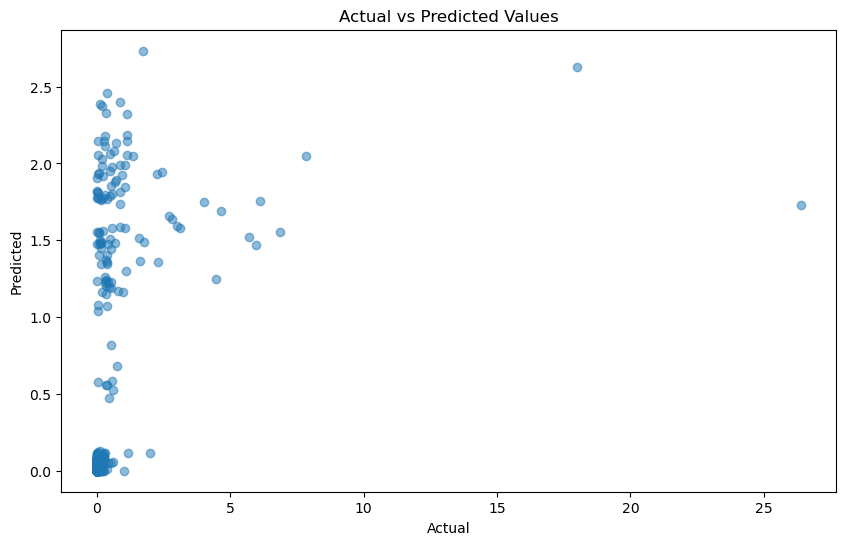

In [12]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.show()

### Visualisation of residuals

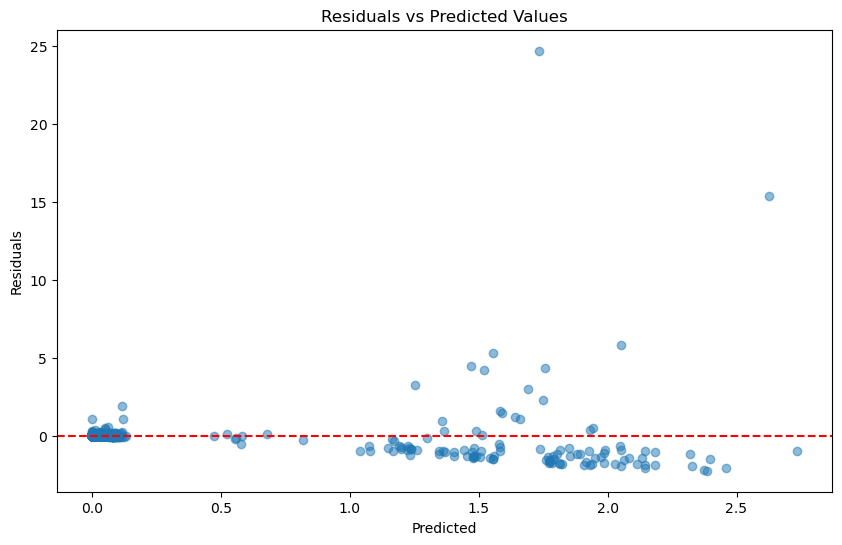

In [13]:
# Plot the residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, y_test - y_pred, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

### View Actual vs Predict

In [14]:
# Create a DataFrame for actual vs predicted values
actual_vs_predicted_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Round the values to 2 decimal places
actual_vs_predicted_df = actual_vs_predicted_df.round(2)

# Display the DataFrame
print(actual_vs_predicted_df.head(10))

      Actual  Predicted
4861    0.05       0.06
548     0.02       0.05
7741    0.00       0.00
551     0.20       0.05
1981    0.00       0.02
7575    0.00       0.01
4528    0.05       0.07
7221    0.00       0.03
2993    0.17       0.05
1280    0.10       1.94


### Make prediction on block model

Import block model for prediction

In [15]:
# Import new data for prediction
bm_file_path = r'C:\Users\Ton\OneDrive\Desktop\Data_Institute\_prj_capstone\BM_26072024_mod.csv'
bm_df = pd.read_csv(bm_file_path)

print(bm_df.head())
print(bm_df.info())

          X          Y    Z  DomCode  Oxidation
0  636605.0  6850125.0 -100        0          3
1  636605.0  6850125.0  -98        0          3
2  636605.0  6850125.0  -96        0          3
3  636605.0  6850125.0  -94        0          3
4  636605.0  6850125.0  -92        0          3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598500 entries, 0 to 598499
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   X          598500 non-null  float64
 1   Y          598500 non-null  float64
 2   Z          598500 non-null  int64  
 3   DomCode    598500 non-null  int64  
 4   Oxidation  598500 non-null  int64  
dtypes: float64(2), int64(3)
memory usage: 22.8 MB
None


In [16]:
# Define the preprocessing steps for numerical and categorical data
numeric_features = ['X', 'Y', 'Z']
categorical_features = ['DomCode', 'Oxidation']

# Preprocessing for numerical data: scaling
numeric_transformer = StandardScaler()

# Preprocessing for categorical data: one-hot encoding
categorical_transformer = OneHotEncoder()

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Apply the preprocessing steps to the new data
bm_df_processed = preprocessor.fit_transform(bm_df)

In [17]:
# Check the feature names and their order after preprocessing
preprocessor.fit(bm_df)
feature_names = numeric_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
print("Feature names after preprocessing:", feature_names)

Feature names after preprocessing: ['X', 'Y', 'Z', 'DomCode_0', 'DomCode_1', 'DomCode_2', 'DomCode_3', 'DomCode_4', 'DomCode_5', 'DomCode_6', 'DomCode_7', 'DomCode_8', 'DomCode_9', 'DomCode_10', 'DomCode_11', 'DomCode_12', 'DomCode_13', 'DomCode_14', 'Oxidation_1', 'Oxidation_2', 'Oxidation_3']


Making prediction

In [18]:
# Make predictions on block model
bm_pred = stacking_model.predict(bm_df_processed).round(2)

# Adjust predictions: if bm_pred < 0, set it to 0
bm_pred = np.where(bm_pred < 0, 0, bm_pred)

# Output predictions (first 100 predictions)
print(bm_pred[:100])

[0.02 0.02 0.02 0.02 0.02 0.02 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.04 0.04 0.04 0.04 0.03 0.03 0.04 0.04 0.04 0.04 0.04
 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.05 0.05 0.04 0.04 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.06 0.06 0.06 0.07 0.07 0.07 0.07 0.08 0.08 0.08 0.08 0.08 0.08
 0.08 0.08 0.08 0.08 0.08 0.08 0.08 0.08 0.09 0.09 0.09 0.09 0.09 0.09
 0.09 0.09]


Combine with the original block model

In [19]:
# Import original block model
bm_original_file_path = r'C:\Users\Ton\OneDrive\Desktop\Data_Institute\_prj_capstone\BM_26072024.csv'
bm_original_df = pd.read_csv(bm_original_file_path)

C:\Users\Ton\AppData\Local\Temp\ipykernel_8904\4102301976.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  bm_original_df = pd.read_csv(bm_original_file_path)


In [20]:
# Add bm_pred as a new column to bm_original_df
bm_combined = bm_original_df
bm_combined['Au_pmm_ML'] = bm_pred

print(bm_combined.head())

          X          Y    Z  Dykes  Density domain  domcode  Au_ppm_KR  \
0  581050.0  6294570.0 -100      0   2810.0    NaN      NaN        NaN   
1  581050.0  6294570.0  -98      0   2810.0    NaN      NaN        NaN   
2  581050.0  6294570.0  -96      0   2810.0    NaN      NaN        NaN   
3  581050.0  6294570.0  -94      0   2810.0    NaN      NaN        NaN   
4  581050.0  6294570.0  -92      0   2810.0    NaN      NaN        NaN   

   Oretype  RESCLASS  Below_Topo  Au_pmm_ML  
0      130       NaN           1       0.02  
1      130       NaN           1       0.02  
2      130       NaN           1       0.02  
3      130       NaN           1       0.02  
4      130       NaN           1       0.02  


Update Au_pmm_ML with Topo and Dykes
- If Below_Topo is 0, set Au_pmm_ML to 0 (indicating air).
- If Dykes is 1, set Au_pmm_ML to 0 (indicating a dyke).

In [21]:
# Apply conditions to update Au_pmm_ML based on Topo and Dykes
bm_combined.loc[bm_combined['Below_Topo'] == 0, 'Au_pmm_ML'] = 0
bm_combined.loc[bm_combined['Dykes'] == 1, 'Au_pmm_ML'] = 0

Save updated dataframe to a new CSV file

In [22]:
# Save the updated dataframe to a new CSV file if needed
bm_combined.to_csv(r'C:\Users\Ton\OneDrive\Desktop\Data_Institute\_prj_capstone\BM_26072024_updated.csv', index=False)
print("Updated dataframe saved successfully.")

Updated dataframe saved successfully.
